# Diffusion Model: Task 1

This notebook includes work performed on task 1 of the project to model diffusion from the inner stream into the bubble. Previously, I used the Epstein-Plesset model to calculate the flux of carbon dioxide into the bubble. This model, however, makes two assumptions that we wish to relax:

1. a constant diffusivity of carbon dioxide in polyol with respect to carbon dioxide concentration
2. a constant carbon dioxide concentration in an infinite bulk. 

In reality, the diffusivity varies strongly with carbon dioxide concentration and the concentration in the bulk depletes as carbon dioxide diffuses from the inner stream into the outer stream. Epstein and Plesset's analytical result for the flux of gas into a bubble in supersaturated liquid relies on these two assumptions, however [1]. 

In task 1, we produce a purely numerical computation of the Epstein-Plesset model that will allow us to relax these assumptions in future tasks. Previously, only the time-stepping was numerically computed, while the Epstein-Plesset analytic model was used to compute the diffusive flux into the bubble at each time step. Here, we also compute this diffusive flux numerically by solving Fick's second law.


**Goal**: Minimize discrepancy in predicted radius between Epstein-Plesset model and purely numerical model for an arbitrary example system.

[1] Epstein, P. S. and Plesset, M. S., *J. Chem. Phys.* **18**, 1505 (1950).

## Setup

### Importing Packages

In [1]:
# adds custom libraries to path
import sys
sys.path.append('../libs/')

# imports standard libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# imports custom libraries
import polyco2
import diffn
import flow
import bubble
import bubbleflow
import analytics as an
import finitediff as fd

# plotting
import plot.diffn as pltd
import plot.bubble as pltb
import plot.genl as pltg

# CONVERSIONS
from conversions import *
# CONSTANTS
from constants import *

from importlib import reload

### Declaring System Parameters

In [2]:
# flow parameters for experiments in 20200905_80bar folder
# viscosity of inner and outer streams [Pa.s]
eta_i = 0.25 # rough estimate of VORANOL 360 + CO2 dissolved so should be lower
eta_o = 4.815
# length of observation capillary [m]
L = 10E-2
# outer stream radius [m]
R_o = 150E-6
Q_o = 200 # outer stream flow rate, input to ISCO 260 D [uL/min]
# inner stream flow rate [uL/min]
Q_i = 100
# saturation pressure [Pa]
p_s = 80E5
# distance down capillary at which measurements were taken in videos of effect of flow rate on 20200905_80bar [m]
d = 0.096

# bubble growth model parameters
dt = 1E-12 # [s]
R_nuc = 5E-6 # [m] arbitrary bubble size for comparing models

# grid parameters
R_max = 100E-6 # outer radius [m]

# diffusion model parameters 
dc_c_s_frac = 0.01 # step size in concentration for estimating dD/dc as a fraction of saturation concentration

# load data (interfacial tension, solubility, and diffusivity) for polyols? we don't have data for VORANOL 360...use 1k3f
polyol_data_file = '1k3f_22c.csv'

# equation of state data
eos_co2_file = 'eos_co2_22-0C.csv'

# plot parameters
t_fs = 18
ax_fs = 16
tk_fs = 14
l_fs = 12

### Calculating Flow Parameters

In [3]:
# computes inner stream radius [m] and velocity [m/s]
dp, R_i, v = flow.get_dp_R_i_v_max(eta_i, eta_o, L, Q_i*uLmin_2_m3s, Q_o*uLmin_2_m3s, R_o, SI=True)
# inlet pressure [Pa]
p_in = P_ATM - dp
# nucleation time [s]
t_nuc = d/v

### Compute Epstein-Plesset Result as a Benchmark

In [4]:
reload(bubble)
# collects relevant parameters
eps_params = (dt, p_s, R_nuc, L, p_in, v, polyol_data_file, eos_co2_file)

# Epstein-Plesset solution for comparison
t_eps, m, D, p_eps, p_bub, if_tension, c_s, c_bulk, R_eps, rho_co2 = bubble.grow(t_nuc, *eps_params)
props_list_eps = (R_eps, m, p_eps, p_bub, rho_co2, if_tension)

# uses 2nd-order Taylor stencil to compute concentration gradient at the surface of the bubble
dcdr_eps = bubble.calc_dcdr_eps(c_bulk, c_s, R_eps, D, np.asarray(t_eps) - t_nuc)

C:\Users\andyl\OneDrive - California Institute of Technology\Documents\Research\Kornfield\ANALYSIS\bubble-growth\bubble.py:233: RuntimeWarning: divide by zero encountered in true_divide
  1/np.sqrt(np.pi*D*(np.asarray(t))))


## ANALYSIS

### Uniform Grid

#### Compute Result

In [5]:
reload(bubbleflow)
# simulation parameters
N = 400
dt = 1E-12 # [s]
D_max = 3E-8 # [m^2/s]
dt_max = 0.5*(R_max/N)**2/D_max
R_max = 100E-6

# performs simulation
t_flow, c, t_num, m, D, p, p_bub, if_tension, \
c_bub, c_bulk, R, rho_co2, v, r_arr_data = bubbleflow.num_fix_D(t_nuc, eps_params, R_max, N, dt_max=dt_max)

#### Plot Result Alongside Epstein-Plesset Result

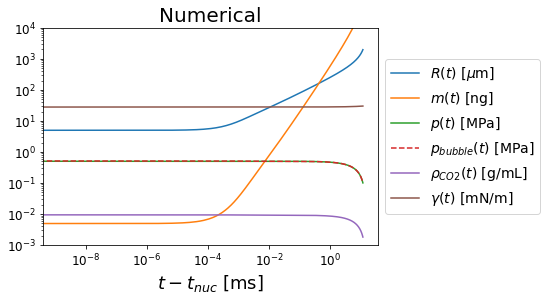

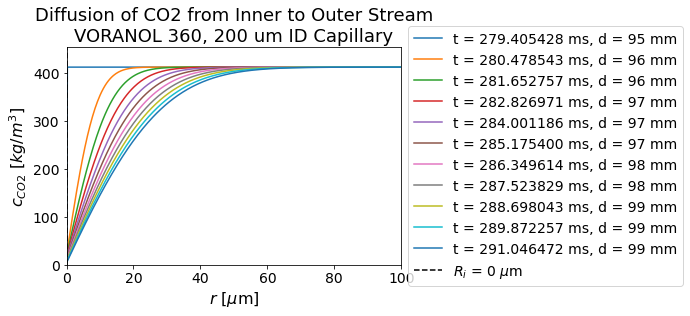

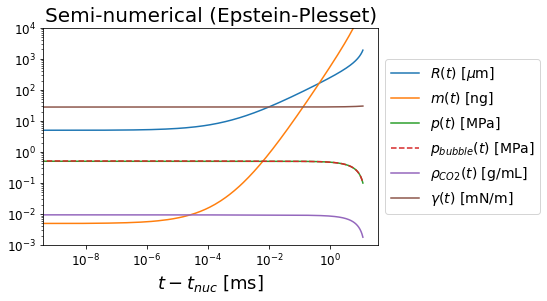

In [6]:
# plotting
props_list_num = (R, m, p, p_bub, rho_co2, if_tension)
ax = pltb.all_props(t_num, t_nuc, props_list_num, x_log=True, title='Numerical')

reload(pltd)
n_plot = 10
r_arr = diffn.make_r_arr_lin(N, R_max)
ax = pltd.sheath(t_flow, r_arr, c, 0, R_max, v, c_bulk, n_plot)

# plots legend outside box
pltg.legend(ax)

### PLOTS EPSTEIN-PLESSET RESULT (semi-numerical)
ax = pltb.all_props(t_eps, t_nuc, props_list_eps, x_log=True, title='Semi-numerical (Epstein-Plesset)')

**Note that when plotting on log(r) scale, the line from r = 0 to the first finite value of r will look horizontal because r = 0 is infinitely far away on a log scale.**

#### Plot Comparison

Text(0.5, 1.0, 'Fractional Error in Radius, N = 400')

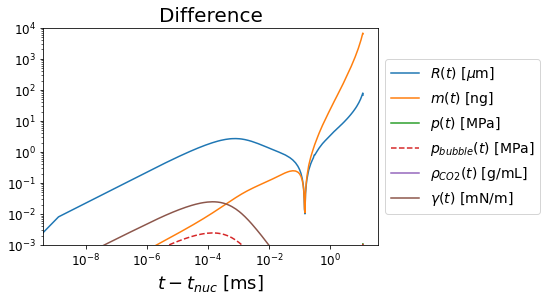

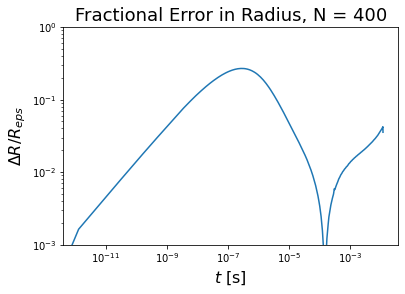

In [8]:
# plots difference in all properties
props_list_diff = [np.abs(np.interp(t_eps, t_num, np.asarray(props_list_num[i])) - np.asarray(props_list_eps[i])) \
                   for i in range(len(props_list_num))]
ax = pltb.all_props(t_eps, t_nuc, props_list_diff, x_log=True, title='Difference')
reload(pltd)
# plots difference in radius
ax = pltd.R_diff(t_eps, props_list_eps[0], t_num, props_list_num[0])
ax.set_title('Fractional Error in Radius, N = {0:d}'.format(N), fontsize=t_fs)

Difference in radius at the end is about 200 um. Seems negligibly affected by N (compared N = 50 and N = 200 @ R_max = 100 um).

For R_max = 200 um (N = 400 to have same grid spacing), difference in radius is still about 200 um at the end.

The diffusivity D and bulk concentration c_bulk are identical for both cases, as expected.

### Compare Difference in Concentration Gradient at Bubble Interface

Plotting the analytical result for the concentration profile in the bulk is challenging due to improper integrals without an explicit form. Instead, I will plot the concentration gradient at the bubble interface, which has an explicit form in the Epstein-Plesset solution,

\begin{align}
\left( \frac{\partial c}{\partial r} \right)_R &= (c_B - c_s) \left[\frac{1}{R} + \frac{1}{\sqrt{\pi D t}} \right] \\
\end{align}

#### Compute Concentration Gradients *WITHOUT LIMIT ON TIME STEP SIZE*

We find that by not limiting the size of the time step, it exceeds the diffusion time scale by the end of the simulation, leading to instabilities that are observed in the plots.

In [9]:
# reload(an)
# # list of N values to consider
# N_list = [50, 100, 200, 400]
# dt_max_list = None

# t_eps, dcdr_eps, t_num_list, dcdr_num_list = an.calc_dcdr_eps_fix_D(N_list, R_max, t_nuc, eps_params)

#### Plot Comparison

In [10]:
# # plots results
# fig = plt.figure()
# ax = fig.add_subplot(111)

# ax.plot(np.asarray(t_eps) - t_eps[0], dcdr_eps, 'b--', label='Epstein-Plesset')

# for N, dcdr_num, t_num in zip(N_list, dcdr_num_list, t_num_list):
#     ax.plot(np.asarray(t_num) - t_num[0], dcdr_num, label='numerical, N = {0:d}'.format(N))


# ax.set_xlabel(r'$t$ [s]', fontsize=16)
# ax.set_ylabel(r'$\frac{dc}{dr}$', fontsize=16)
# ax.set_xscale('log')
# ax.set_yscale('log')

# plt.legend()

# # plot difference
# dcdr_diff_list = []
# label_list = []
# reload(pltd)
# for N, dcdr_num, t_num in zip(N_list, dcdr_num_list, t_num_list):
#     # computes fractional differencies in concentration gradient
#     dcdr_diff_list += [np.abs(np.interp(t_eps, t_num, dcdr_num) - np.asarray(dcdr_eps)) / np.asarray(dcdr_eps)]
#     label_list += ['N = {0:d}'.format(N)]
    
# # plots discrepancies
# ax = pltd.dcdr_diff(t_eps, dcdr_diff_list, label_list)
# ax.set_title('Discrepancy in Concentration Gradient vs. N')

We see large oscillations indicative of instability at later times. These are the result of the time step exceeding the diffusion time scale, $\tau \sim (\Delta r)^2/D$. 

#### Compute Concentration Gradients *LIMITING TIME STEP TO DIFFUSION TIME SCALE*

In [11]:
reload(fd)
reload(an)
# list of N values to consider
N_list = [50, 100, 200, 400]
dt_max_list = [0.5*(R_max/N)**2/D for N in N_list] # dt < half of diffusive time scale [s]

t_eps, dcdr_eps, t_num_list, dcdr_num_list = an.calc_dcdr_eps_fix_D(N_list, R_max, t_nuc, eps_params, 
                                                                    dt_max_list=dt_max_list)

C:\Users\andyl\OneDrive - California Institute of Technology\Documents\Research\Kornfield\ANALYSIS\bubble-growth\bubble.py:233: RuntimeWarning: divide by zero encountered in true_divide
  1/np.sqrt(np.pi*D*(np.asarray(t))))


C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


Text(0.5, 1.0, 'Discrepancy in Concentration Gradient vs. N')

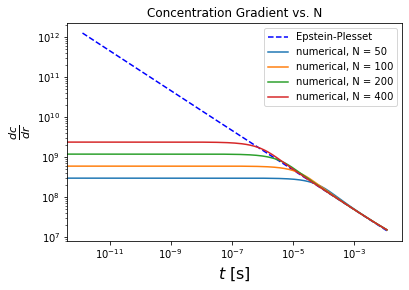

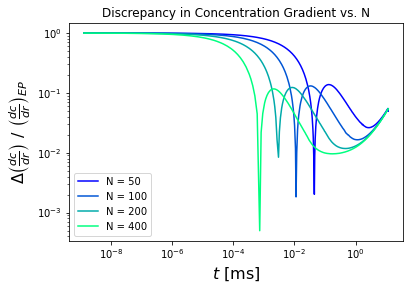

In [12]:
# plots results
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(np.asarray(t_eps) - t_eps[0], dcdr_eps, 'b--', label='Epstein-Plesset')

for N, dcdr_num, t_num in zip(N_list, dcdr_num_list, t_num_list):
    ax.plot(np.asarray(t_num) - t_num[0], dcdr_num, label='numerical, N = {0:d}'.format(N))


ax.set_xlabel(r'$t$ [s]', fontsize=16)
ax.set_ylabel(r'$\frac{dc}{dr}$', fontsize=16)
ax.set_xscale('log')
ax.set_yscale('log')

plt.legend()
ax.set_title('Concentration Gradient vs. N')

# plot difference
dcdr_diff_list = []
label_list = []
reload(pltd)
for N, dcdr_num, t_num in zip(N_list, dcdr_num_list, t_num_list):
    # computes fractional differencies in concentration gradient
    dcdr_diff_list += [np.abs(np.interp(t_eps, t_num, dcdr_num) - np.asarray(dcdr_eps)) / np.asarray(dcdr_eps)]
    label_list += ['N = {0:d}'.format(N)]
    
# plots discrepancies
ax = pltd.diff(t_eps, dcdr_diff_list, label_list)
ax.set_title('Discrepancy in Concentration Gradient vs. N')

The error in the concentration gradient at the beginning is unavoidable because the derivative is infinite at the nucleation time in the Epstein-Plesset model.

**Why is the concentration gradient a consistent overestimate at later times?** My guess would be that due to the gross underestimate in the concentration gradient at early times, the diffusive flux of CO2 into the bubble is slower initially, resulting in a shorter diffusion layer and a steeper concentration gradient.

Could it be...
- The diffusion volume is large enough that it feels the effect of the finite size of the domain, resulting in some flux from the boundary of CO2 that increases the flux into the bubble?
    *No, increasing the domain size to 200 $\mu$m had no noticeable effect on the error in the bubble radius*
- The decrease in pressure in the bubble results in greater flux than in Epstein-Plesset (does my E-P model account for this?)?
    *No, the Epstein-Plesset model accounts for pressure change*
- The difference in Tolman length? The Epstein-Plesset model was still using 0 nm, whereas the numerical model was using 5 nm.
    *No, the errors are just as high when I change the Tolman length to 5 nm for the Epstein-Plesset model.
    
**Resolved in `diffn_model_task1_debug.ipynb` by fixing bug in `bubble.adapt_time_step()`.**

Further improvements in accuracy will need to resolve the interface more sharply. This would be done best by a logarithmically spaced grid.

### Adjust Spatial Resolution During Computation

Based on the above results, a fine grid is most beneficial at early times, but a coarser grid seems to give more accurate results (in addition to permitting longer time steps without becoming unstable) at later times. I will utilize this behavior by coarsening the grid for the radius $r$ by removing every other point once there are at least 10 points resolving the concentration gradient at the surface of the bubble (10 is just a guess for now).

In [ ]:
reload(diffn)
reload(bubbleflow)

# simulation parameters
N0 = 800
dt = 1E-12 # [s]
D_max = 3E-8 # [m^2/s]
dt_max = 0.5*(R_max/N0)**2/D_max
remesh_fn = diffn.manage_grid_halving
remesh_params = {'pts_per_grad' : 5}

# performs simulation
t_flow, c, t_num, m, D, p, p_bub, if_tension, \
c_bub, c_bulk, R, rho_co2, v, r_arr_data = bubbleflow.num_vary_D(t_nuc, eps_params, R_max, N0, dc_c_s_frac, dt_max=dt_max, 
                                                      D_fn=diffn.fixed_D, remesh_fn=remesh_fn, remesh_params=remesh_params)

#### Plot Results

In [ ]:
reload(pltd)
r_arr_list = [diffn.make_r_arr_lin(int(R_max/dr), R_max) for dr in dr_list]
n_plot = 8
ax1, ax2 = pltd.bubble_sheath(R, m, p, p_bub, rho_co2, if_tension, t_num, t_nuc, t_flow, 
                              r_arr_list, c, R_max, v, c_bulk, n_plot)

### Adjust Spatial Resolution During Computation

Based on the above results, a fine grid is most beneficial at early times, but a coarser grid seems to give more accurate results (in addition to permitting longer time steps without becoming unstable) at later times. I will utilize this behavior by coarsening the grid for the radius $r$ by removing every other point once there are at least 10 points resolving the concentration gradient at the surface of the bubble (10 is just a guess for now).

In [ ]:
# simulation parameters
N0 = 800
dt = 1E-12 # [s]
D_max = 3E-8 # [m^2/s]
dt_max = 0.5*(R_max/N0)**2/D_max
half_grid = True

# performs simulation
t_flow, c, t_num, m, D, p, p_bub, if_tension, \
c_bub, c_bulk, R, rho_co2, v, dr_list = bubbleflow.num_fix_D(t_nuc, eps_params, R_max, N0, dc_c_s_frac, dt_max=dt_max, 
                                                              half_grid=half_grid)

#### Plot Results

In [ ]:
r_arr_list = [diffn.make_r_arr_lin(int(R_max/dr), R_max) for dr in dr_list]
n_plot = 8
ax1, ax2 = pltd.bubble_sheath(R, m, p, p_bub, rho_co2, if_tension, t_num, t_nuc, t_flow, 
                              r_arr_list, c, R_max, v, c_bulk, n_plot)

### Compare Numerical with Grid-halving to Semi-numerical Epstein-Plesset Model

In [ ]:
# uses 2nd-order Taylor stencil
dcdr_num = [fd.dydx_fwd_2nd(c[i][0], c[i][1], c[i][2], dr_list[i]) \
                    for i in range(len(c))]

# finds times when halving took place
dr_diff = np.diff(dr_list)
i_halved = np.where(dr_diff > 0)[0]
t_halved_list = [[t_flow[i]-t_nuc for i in i_halved]]

# plots difference
dcdr_diff_list = [an.calc_diff(t_eps, dcdr_eps, t_num, dcdr_num)]
label_list = [r'$N_0 =$' + ' {0:d}'.format(N0)]
ax = pltd.diff(t_eps, dcdr_diff_list, label_list, t_halved_list)

### Compare Radius Error

#### Without Grid Halving

In [ ]:
# fixed inputs
D_fn = diffn.fixed_D

# varied inputs
# 1) N = 50 (2) N = 800 (3) N = 800 without grid halving
N_ = [50, 200, 800]
half_grid_ = [False, False, False]
dt_max_ = [0.5*(R_max/N)**2/D_max for N in N_]

# collects bubble-growth functions
num_fn_list = [bubbleflow.num_vary_D] * len(N_)
# groups inputs for each function
num_input_list = [(t_nuc, eps_params, R_max, N_[i], dc_c_s_frac, dt_max_[i], D_fn, half_grid_[i]) for i in range(len(N_))]

In [ ]:
R_diff_list, dr_list_list, raw_vals_list = an.compare_R(num_input_list, num_fn_list, t_eps, R_eps)

#### Plot Results

In [ ]:
# creates labels
label_list = []
# stores times at which grid was halved 
t_halved_list = []

for N, half_grid, dr_list in zip(N_, half_grid_, dr_list_list):
    label = r'$N_0 =$' + ' {0:d}'.format(N)
    label_list += [label]
    
    # times at which the grid was halved
    dr_diff = np.diff(dr_list)
    i_halved = np.where(dr_diff > 0)[0]
    t_halved_list += [[t_flow[i]-t_nuc for i in i_halved]]
    
ax = pltd.diff(t_eps, R_diff_list, label_list, t_halved_list)

ax = pltd.diff(t_eps, R_diff_list, label_list, None)
ax.set_ylabel(r'$\Delta R/R_{EP}$', fontsize=ax_fs)
ax.set_ylim([1E-3, 1])

#### With Grid Halving

In [ ]:
reload(diffn)
reload(bubbleflow)
# fixed inputs
D_fn = diffn.fixed_D

# varied inputs
# 1) N = 50 (2) N = 800 (3) N = 800 (4) N = 3200 with grid halving
N_ = [50, 200, 800, 3200]
pts_per_grad = 10

# collects bubble-growth functions
num_fn_list = [bubbleflow.num_vary_D] * len(N_)
# groups inputs for each function
num_input_list = [{'t_nuc' : t_nuc, 'eps_params' : eps_params, 'R_max' : R_max, 'N' : N_[i], 'dc_c_s_frac' : dc_c_s_frac,
                   'dt_max' : dt_max_[i], 'D_fn' : D_fn, 'remesh_fn' : diffn.manage_grid_halving,
                  'remesh_params' : {'pts_per_grad' : pts_per_grad}} for i in range(len(N_))]

In [ ]:
R_diff_list, r_arr_data_list, raw_vals_list = an.compare_R(num_input_list, num_fn_list, t_eps, R_eps)

#### Plot Results

In [ ]:
# creates labels
label_list = []
# stores times at which grid was halved 
t_halved_list = []

for N, half_grid, dr_list in zip(N_, half_grid_, dr_list_list):
    label = r'$N_0 =$' + ' {0:d}'.format(N)
    label_list += [label]
    
    # times at which the grid was halved
    dr_diff = np.diff(dr_list)
    i_halved = np.where(dr_diff > 0)[0]
    t_halved_list += [[t_flow[i]-t_nuc for i in i_halved]]
    
ax = pltd.diff(t_eps, R_diff_list, label_list, t_halved_list)

ax = pltd.diff(t_eps, R_diff_list, label_list, None)
ax.set_ylabel(r'$\Delta R/R_{EP}$', fontsize=ax_fs)
ax.set_ylim([1E-3, 1])

Looking pretty good at $N_0 = 3200$. I wish I could lower the plateau at 10% error. It doesn't seem like the spikes in $\frac{dc}{dr}$ have a significant effect on the discrepancy in the radius.

**Further improvements might be achieved by using logarithmic spacing of points to focus mesh points near the interface. This will be explored in** `diffn_model_task1a.ipynb`.